In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def divideArrayIntoBatches (array, num_divisions) -> list:
    """
    Divides a 2D array into 16 batches.
    
    Args:
        array: a 2D numpy array.
        num_divisions: The number of divisions to use.

    Returns:
    A list of 16 2D numpy arrays, each of which is a batch of the input array.
    """

    if len (array.shape) != 2:
        raise ValueError ("Input array must be 2D")

    num_rows, num_cols = array.shape

    if num_rows == 0 or num_cols == 0:
        return []
    
    batch_size_rows = (num_rows) // num_divisions
    batch_size_cols = (num_cols) // num_divisions

    batches = []
    for i in range (num_divisions):
        for j in range (num_divisions):
            batch = array [i * batch_size_rows: (i + 1) * batch_size_rows,
                           j * batch_size_cols: (j + 1) * batch_size_cols]
            batches.append (batch)

    return batches

def exportToExcel (array, str = 'diff.xlsx'):
    import pandas as pd

    temp = pd.DataFrame (array)
    temp.to_excel (str);


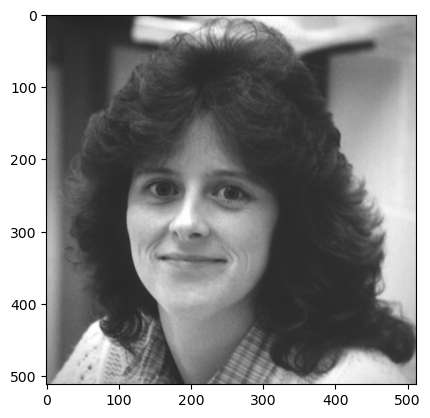

(512, 512)
<class 'numpy.ndarray'>
[[ 40  38  38 ... 160 159 149]
 [ 43  40  41 ... 160 159 148]
 [ 41  41  40 ... 160 159 149]
 ...
 [131 131 134 ... 159 159 151]
 [132 132 133 ... 159 159 150]
 [131 131 131 ... 158 157 148]]


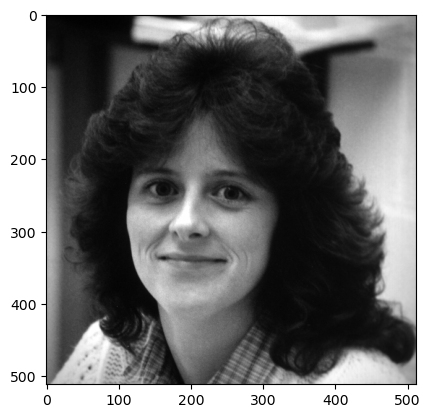

In [4]:
import cv2 as cv

pic_address = 'test_pics\\standard cases\\woman_darkhair.tif'

pic_src = cv.imread (pic_address)

pic_org = cv.cvtColor(pic_src, cv.COLOR_BGR2RGB)
plt.imshow (pic_org)
plt.show ()

pic = cv.cvtColor(pic_src, cv.COLOR_BGR2GRAY)
print (pic.shape)
print (type (pic))
print (pic [:,:])


plt.imshow (pic [:, :], cmap= 'gray')
plt.show ()

pic shape:  (512, 512)


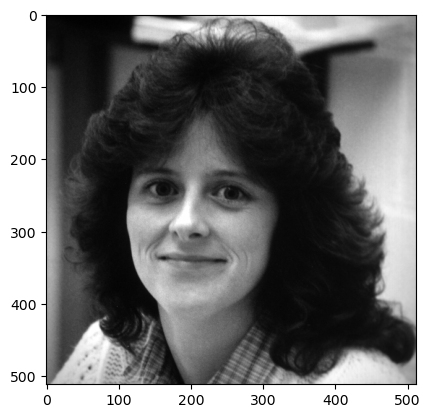

In [5]:
pic = cv.imread (pic_address)
pic = cv.cvtColor(pic, cv.COLOR_BGR2GRAY)
pic = divideArrayIntoBatches (pic, 1) [0]

print ('pic shape: ',pic.shape)

plt.imshow (pic, cmap = 'gray')
plt.show ()

initial Acoefs:  [0.27556077 0.25092811 0.24485895 0.25584059]
Optimized Acoefs:  [0.28226767 0.22204703 0.22850992 0.26731749]


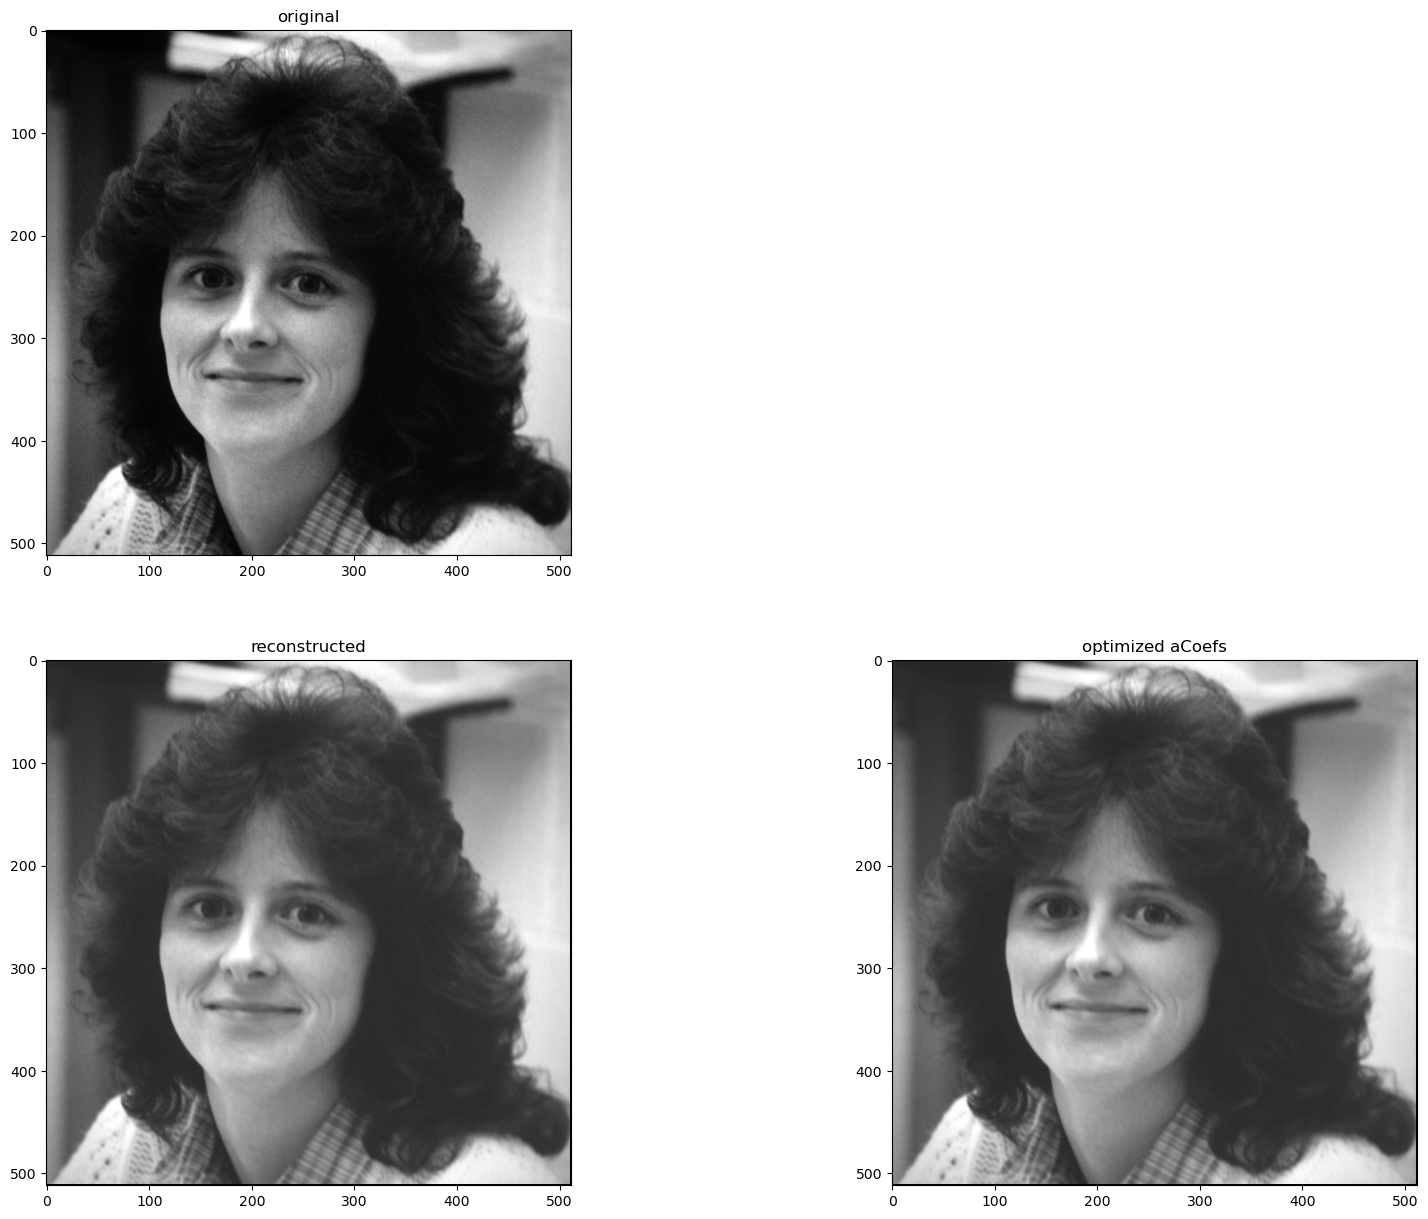

MSE Score:254.40432436944317

MSE Score:242.0059821244738



In [7]:
# Compression:
def calculateACoefs (pic):
    """
        Calculates the aCoefs using the given 2D numpy array (pic)

        Args:
            pic: a 2D numpy array representing the picture.

        Returns:
            aCoefs: a 1D numpy arrau containing the calculated aCoefs.
    """
    import numpy as np
    from numpy import mean

    R22 = R33 = R44 = R55 = mean (mean (pic * pic))
    R12 = R34 = R45 = mean ( mean (pic[: , 1:-1] * pic[: , 2:]))
    R13 = mean (mean (pic[1:-1, 1:-1] * pic[2:, 2:]))
    R14 = R23 = mean (mean (pic[1:-1 , :] * pic[2:, :]))
    R15 = R24 = mean (mean (pic[2:, 1:-1] * pic[1:-1, 2:]))
    R25 = mean (mean (pic[1:-1, 3:] * pic[2:, 1:-2]))
    R35 = mean (mean (pic[:, 3:] * pic[:, 1:-2]))

    Phi = np.array ([[R22, R23, R24, R25],
                    [R23, R22, R34, R35],
                    [R24, R34, R22, R45],
                    [R25, R35, R45, R22]])

    R = np.array ([R12, R13, R14, R15])

    # print ('Phi:\n', Phi)
    # print ('R:\n', R)

    # aCoefs = np.linalg.inv(Phi) @ R
    aCoefs = np.linalg.solve (Phi, R)

    # print ('\nPhi:\n{}\n'.format (Phi))
    # print ('R:\n{}\n'.format (R))
    # print ('aCoefs:\n{}\n'.format (aCoefs))

    return aCoefs

# Reconstruction:
def reconstructPicfromACoefs (aCoefs, pic):
    """
    Reconstructs the image using the given 2D numpy array (pic) and aCoefs.

    Args:
        aCoefs: a 1D numpy array containing aCoefs.
        pic: a 2D numpy array representing the picture. 

    Returns:
        pic_recons_frompic: a 2D numpy array representing the recontructed image using the original image.

    """

    pic_recons_fromzero = np.zeros (pic.shape, dtype='double')
    pic_recons_fromzero[:,0] = pic[:,0]
    pic_recons_fromzero[0,:] = pic[0,:]

    # print ('pic_recons size: {}'.format (pic_recons_fromzero.shape))


    for i in range (1 , pic.shape[0]-1):
        for j in range (1, pic.shape[1]-1):
            pic_recons_fromzero [i, j] = aCoefs[0]*pic_recons_fromzero[i-1,j] + aCoefs[1]*pic_recons_fromzero[i-1,j+1] + aCoefs[2]*pic_recons_fromzero[i,j+1] + aCoefs[3]*pic_recons_fromzero[i+1,j+1]

    # plt.imshow (pic_recons_fromzero)

    pic_recons_frompic = np.zeros (pic.shape, dtype='double')

    # for i in range (1 , pic.shape[0]-1):
    #     for j in range (1, pic.shape[1]-1):
    #         pic_recons_frompic [i, j] = aCoefs[0]*pic[i-1,j] + aCoefs[1]*pic[i-1,j+1] + aCoefs[2]*pic[i,j+1] + aCoefs[3]*pic[i+1,j+1]

    # more efficient alternative:
    pic_recons_frompic[1:-1, 1:-1] = aCoefs[0] * pic[:-2, 1:-1] + aCoefs[1] * pic[:-2, 2:] + aCoefs[2] * pic[1:-1, 2:] + aCoefs[3] * pic[2:, 2:]

    return pic_recons_frompic

# Optimize Acoefs
def optimizeAcoefs (aCoefs, pic, reconstructed_pic, max_iterations=100) :
    import numpy as np

    def calculateDiff (aCoefs, pic, reconstructed_pic):

        diff = np.sum (np.abs (pic - reconstructPicfromACoefs (aCoefs, pic)))
        return diff
    
    # aCoefs = np.random.rand (4)
    step_size = 0.01
    tolerance = 1e-6

    diff = calculateDiff (aCoefs, pic, reconstructed_pic)

    for i in range (max_iterations):
        new_aCoefs = aCoefs + np.random.normal (0, step_size, size=4)
        new_diff = calculateDiff (new_aCoefs, pic, reconstructed_pic)

        if new_diff < diff:
            aCoefs = new_aCoefs
            diff = new_diff

        if diff < tolerance:
            break
    
    return aCoefs

# MSE Score: 
def mse(img1, img2): # MSE Score
   h, w = img1.shape
   diff = abs (img1 - img2)
   err = np.sum(diff**2)
   mse = err/(float(h*w))
   return mse

aCoefs = calculateACoefs (pic)
aCoefs_optimized = optimizeAcoefs (aCoefs, pic, reconstructPicfromACoefs (aCoefs, pic))
print ('initial Acoefs: ', aCoefs)
print ('Optimized Acoefs: ', aCoefs_optimized)

# pic_recons_frompic = reconstructPicfromACoefs (calculateACoefs (pic), pic)
pic_recons_frompic = reconstructPicfromACoefs (aCoefs, pic)
pic_recons_frompic_optimized = reconstructPicfromACoefs (aCoefs_optimized, pic)

plt.figure (figsize=(20,15))
plt.subplot (2,2,3)
plt.imshow (pic_recons_frompic, cmap='gray')
plt.title (label='reconstructed')
plt.subplot (2,2,1)
plt.imshow (pic, cmap='gray')
plt.title (label='original')
plt.subplot (2,2,4)
plt.imshow (pic_recons_frompic_optimized, cmap= 'gray')
plt.title (label='optimized aCoefs')
plt.show()


mse_score = mse(pic, pic_recons_frompic)
print ('MSE Score:{}\n'.format (mse_score))
print ('MSE Score:{}\n'.format (mse (pic, pic_recons_frompic_optimized)))


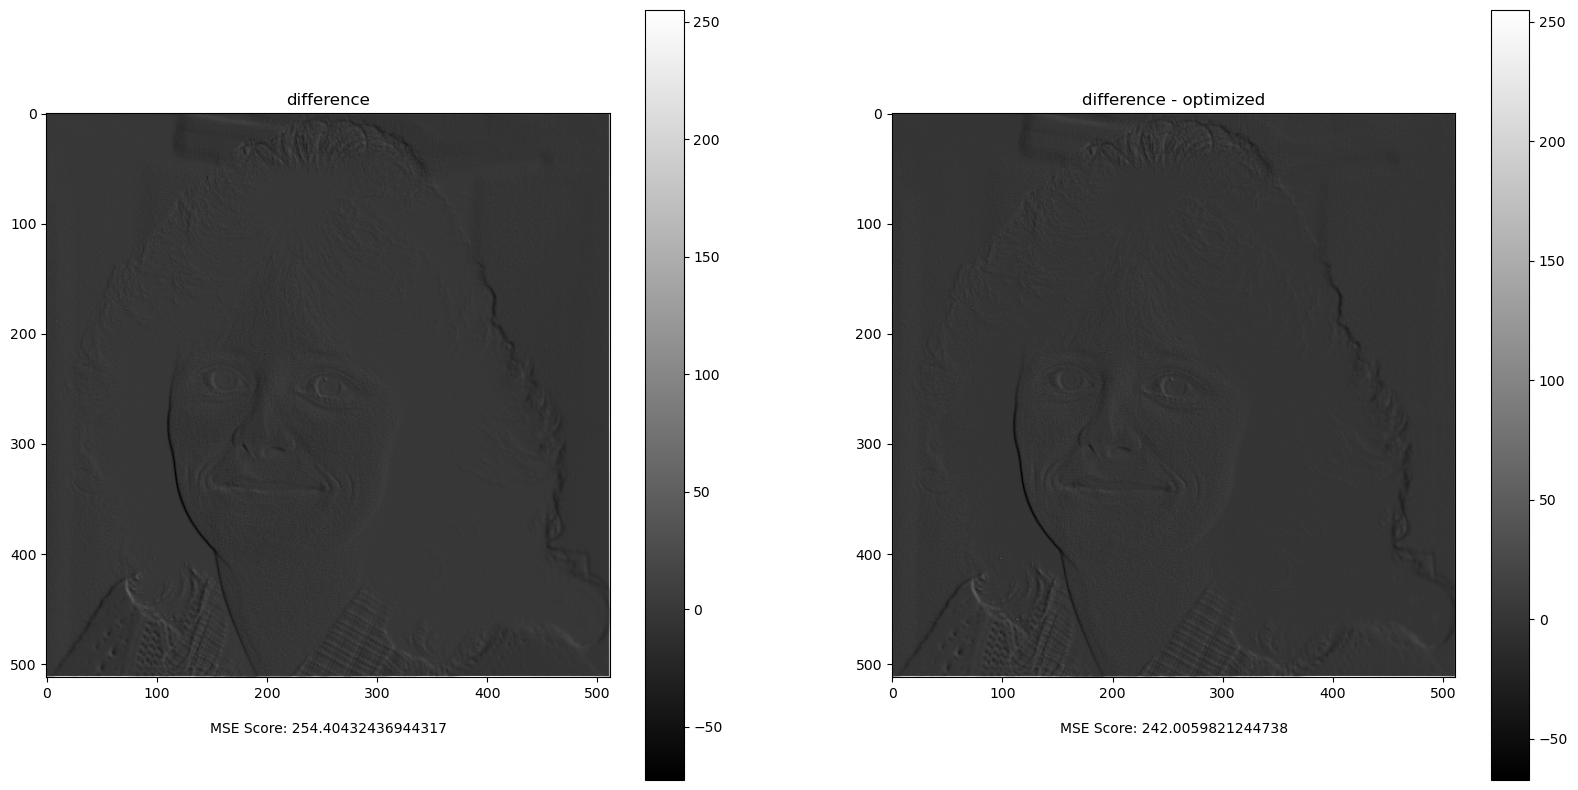

[[ 40.          38.          38.         ... 160.         159.
  149.        ]
 [ 43.          -0.27941773   0.46358501 ...  -3.59851844   3.43817775
  148.        ]
 [ 41.          -0.33846463  -1.61893787 ...  -3.59851844   3.4442469
  149.        ]
 ...
 [131.          -6.13647865  -2.62212809 ...  -5.37593542   0.89292634
  151.        ]
 [132.          -3.80418433  -3.89653218 ...  -3.8112765    2.70244422
  150.        ]
 [131.         131.         131.         ... 158.         157.
  148.        ]]


In [8]:
# plt.imshow (cv.absdiff (pic, pic_recons_frompic), cmap= 'YlOrBr')

def createDiffMatrix (pic, pic_recons):
    return pic - pic_recons

diff = createDiffMatrix(pic, pic_recons_frompic)

plt.figure (figsize=(20,10))
plt.subplot (1,2,1)
# plt.imshow (diff, cmap= 'YlOrBr')
plt.imshow (createDiffMatrix (pic, pic_recons_frompic), cmap= 'gray')
plt.title (label='difference')
plt.xlabel ('\nMSE Score: {}'.format (mse (pic, pic_recons_frompic)))
plt.colorbar ()

plt.subplot (1,2,2)
plt.imshow (createDiffMatrix (pic, pic_recons_frompic_optimized), cmap = 'gray')
plt.title (label = 'difference - optimized')
plt.xlabel ('\nMSE Score: {}'.format (mse (pic, pic_recons_frompic_optimized)))
plt.colorbar ()

plt.show()

print (diff)

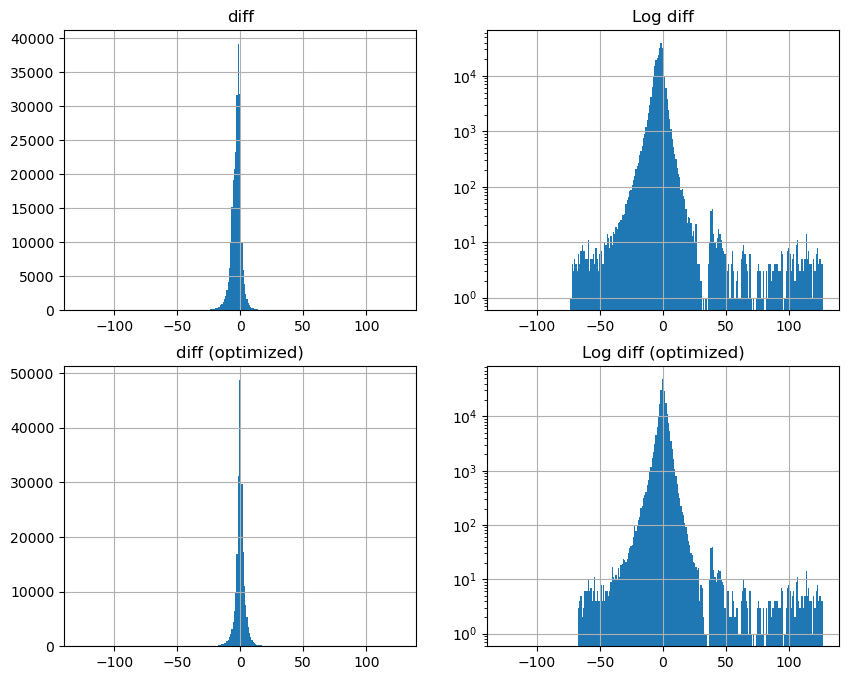

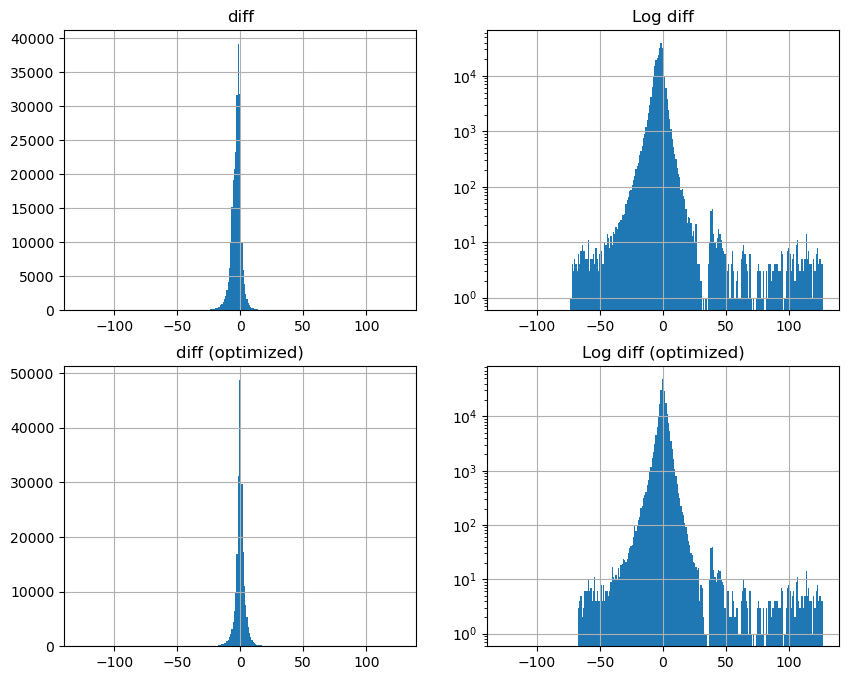

In [13]:
fig = plt.figure (figsize= (10, 8))
plt.subplot (2,2,1)
plt.hist (createDiffMatrix(pic, pic_recons_frompic).ravel(), 256, [-127, 127])
plt.title ('diff')
plt.grid ()
plt.subplot (2,2,2)
plt.hist (createDiffMatrix(pic, pic_recons_frompic).ravel(), 256, [-127, 127], log=True)
plt.title ('Log diff')
plt.grid ()

plt.subplot (2,2,3)
plt.hist (createDiffMatrix(pic, pic_recons_frompic_optimized).ravel(), 256, [-127, 127])
plt.title ('diff (optimized)')
plt.grid ()
plt.subplot (2,2,4)
plt.hist (createDiffMatrix(pic, pic_recons_frompic_optimized).ravel(), 256, [-127, 127], log=True)
plt.title ('Log diff (optimized)')
plt.grid ()



plt.show ()

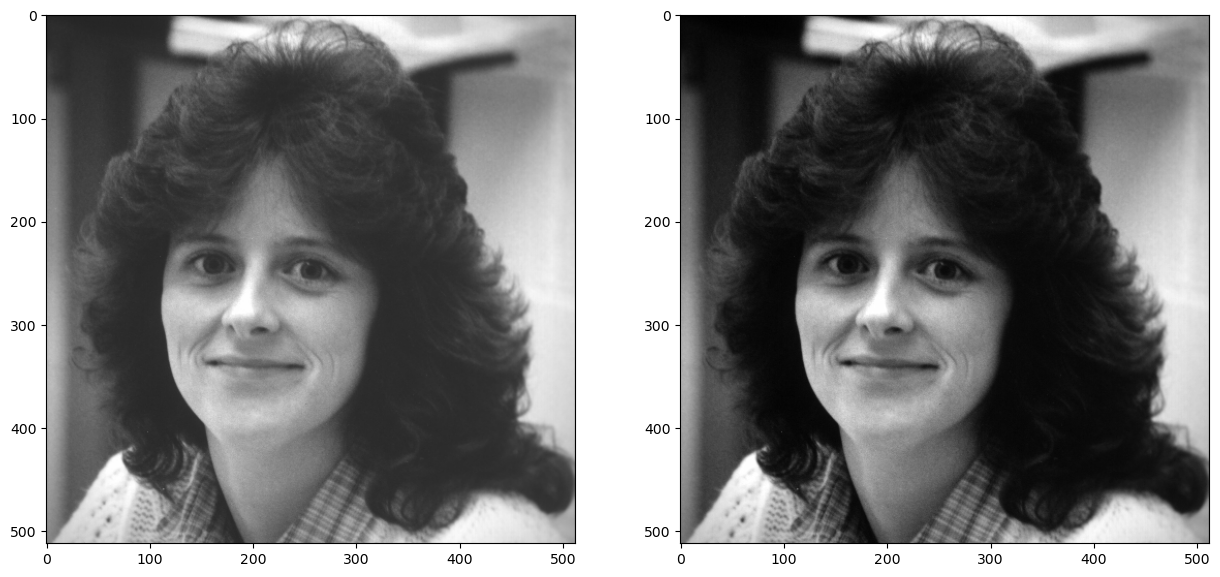

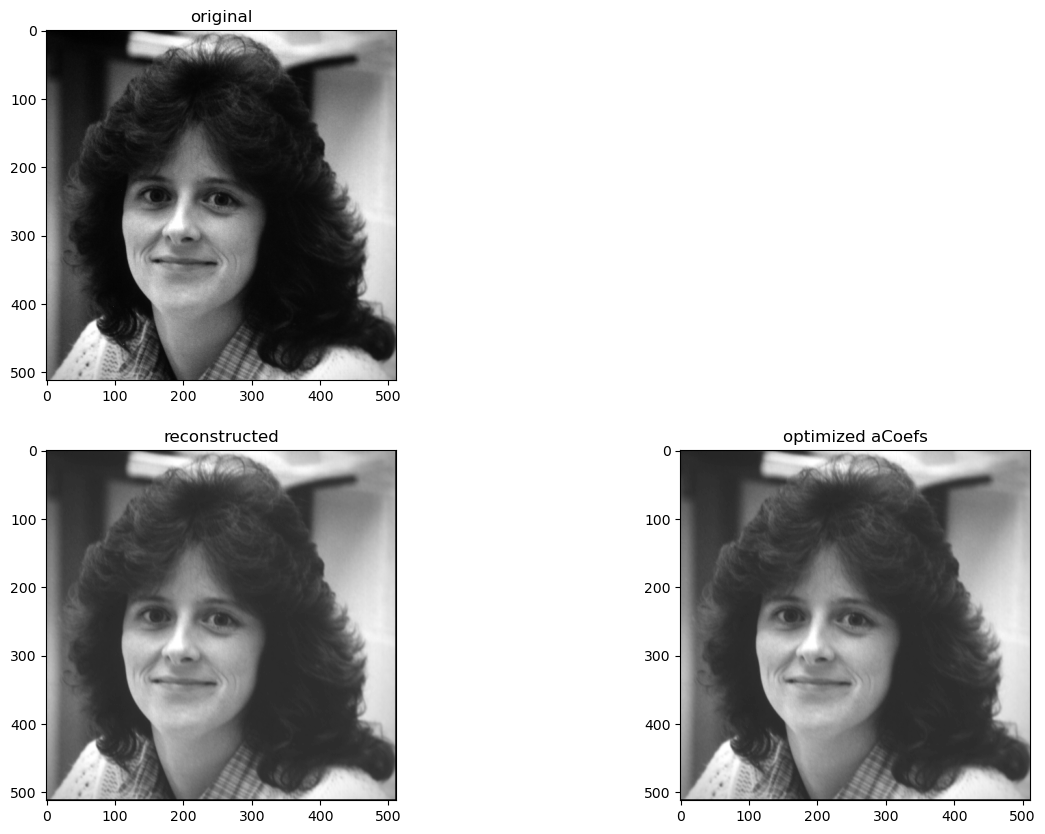

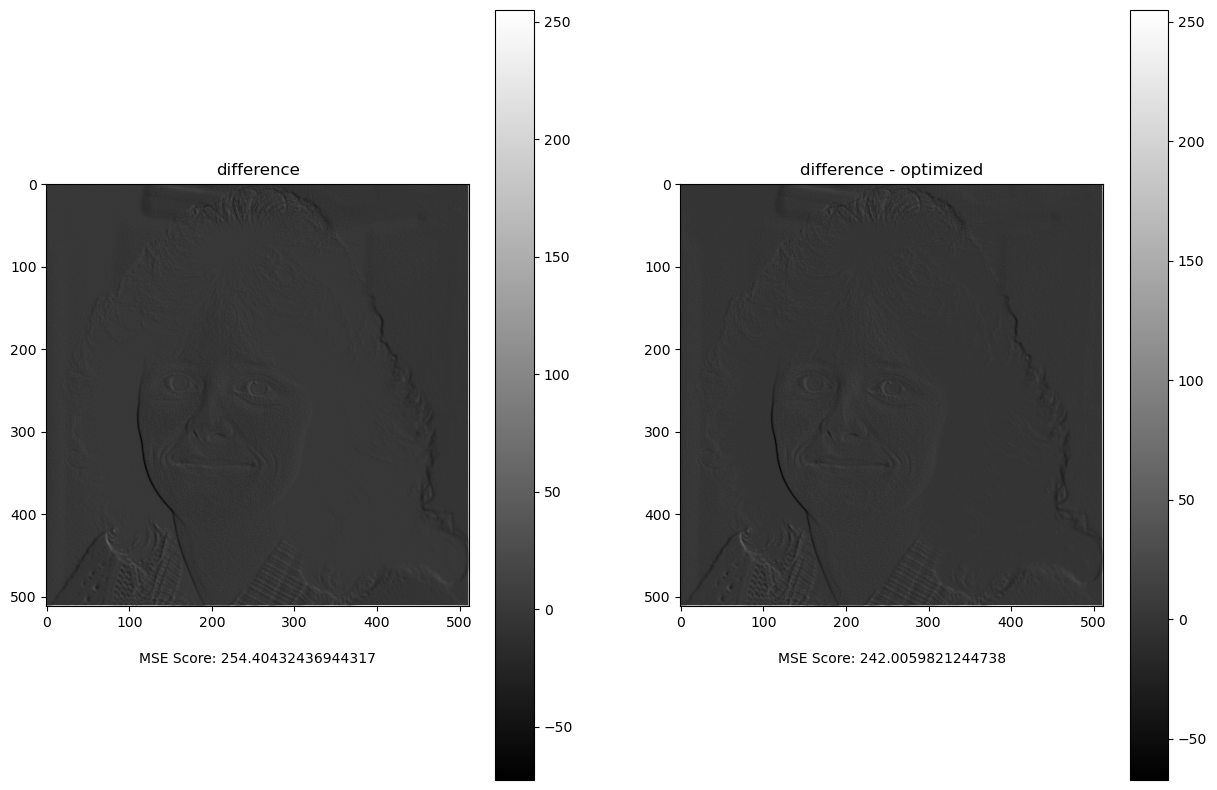

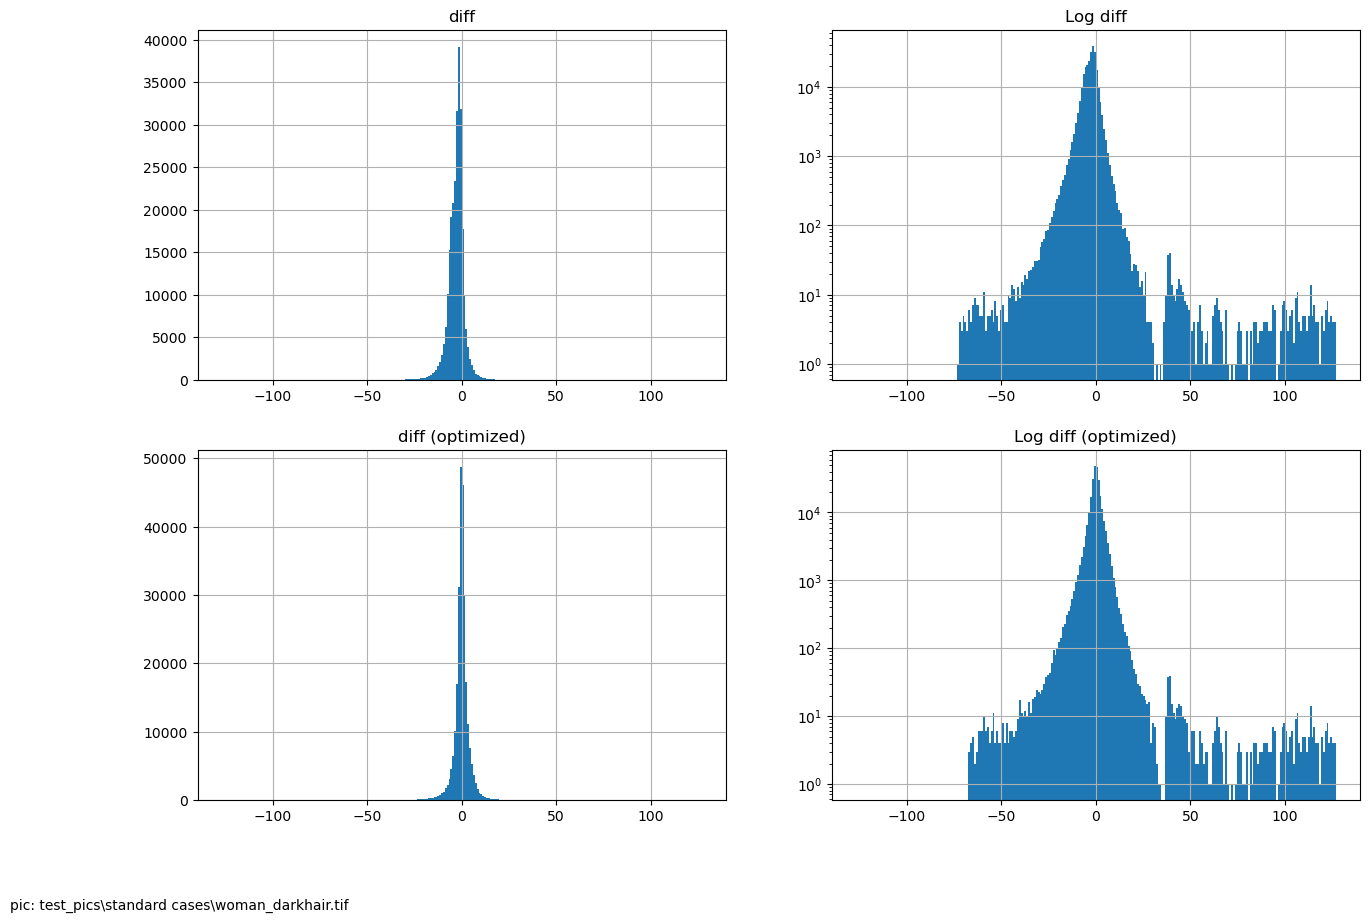

In [10]:
def report_2 ():

    plt.figure (figsize= (15, 10))
    plt.subplot (1,2,1)
    plt.imshow (pic_org)
    plt.subplot (1,2,2)
    plt.imshow (pic, cmap= 'gray')
    plt.show ()


    plt.figure (figsize= (15, 10))
    plt.subplot (2,2,3)
    plt.imshow (pic_recons_frompic, cmap='gray')
    plt.title (label='reconstructed')
    plt.subplot (2,2,1)
    plt.imshow (pic, cmap='gray')
    plt.title (label='original')
    plt.subplot (2,2,4)
    plt.imshow (pic_recons_frompic_optimized, cmap= 'gray')
    plt.title (label='optimized aCoefs')
    plt.show()




    plt.figure (figsize= (15, 10))
    plt.subplot (1,2,1)
    plt.imshow (createDiffMatrix (pic, pic_recons_frompic), cmap= 'gray')
    plt.title (label='difference')
    plt.xlabel ('\nMSE Score: {}'.format (mse (pic, pic_recons_frompic)))
    plt.colorbar ()

    plt.subplot (1,2,2)
    plt.imshow (createDiffMatrix (pic, pic_recons_frompic_optimized), cmap = 'gray')
    plt.title (label = 'difference - optimized')
    plt.xlabel ('\nMSE Score: {}'.format (mse (pic, pic_recons_frompic_optimized)))
    plt.colorbar ()
    plt.show()
    


    plt.figure (figsize= (15, 10))
    plt.subplot (2,2,1)
    plt.hist (createDiffMatrix(pic, pic_recons_frompic).ravel(), 256, [-127, 127])
    plt.title ('diff')
    plt.grid ()
    plt.subplot (2,2,2)
    plt.hist (createDiffMatrix(pic, pic_recons_frompic).ravel(), 256, [-127, 127], log=True)
    plt.title ('Log diff')
    plt.grid ()

    plt.subplot (2,2,3)
    plt.hist (createDiffMatrix(pic, pic_recons_frompic_optimized).ravel(), 256, [-127, 127])
    plt.title ('diff (optimized)')
    plt.grid ()
    plt.subplot (2,2,4)
    plt.hist (createDiffMatrix(pic, pic_recons_frompic_optimized).ravel(), 256, [-127, 127], log=True)
    plt.title ('Log diff (optimized)')
    plt.grid ()
    plt.figtext (0, 0, 'pic: {}'.format (pic_address))
    plt.show ()


report_2 ()

In [11]:
pic_recons_frompic_optimized.shape

(512, 512)

In [ ]:
import os

directory = os.fsencode ('test_pics/Farshchian')

for file in os.listdir (directory):
    filename = os.fsdecode (file)
    